# Variational Deep Embedding - PyTorch Implementation

## CS 6140 Project
### Team: Harish Akula

## MNIST Clustering - Baselines

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype('int')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Apply PCA

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 50 dimensions
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [ ]:
import numpy as np

### Apply K-Means on PCA data

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from scipy.stats import mode


# Map clusters to labels using majority vote
def map_clusters_to_labels(y_true, y_pred, n_clusters=10):
    labels = np.zeros_like(y_pred)
    for i in range(n_clusters):
        mask = (y_pred == i)
        if np.sum(mask) == 0:
            continue
        labels[mask] = mode(y_true[mask])[0]
    return labels


### Apply GMM on PCA data

In [ ]:
kmeans = KMeans(n_clusters=10, n_init='auto', random_state=42)
kmeans.fit(X_train_pca)
kmeans_test_preds = kmeans.predict(X_test_pca)
kmeans_labels = map_clusters_to_labels(y_test, kmeans_test_preds)

# Evaluation
kmeans_acc = accuracy_score(y_test, kmeans_labels)
kmeans_nmi = normalized_mutual_info_score(y_test, kmeans_test_preds)
print(f"KMeans Accuracy: {kmeans_acc:.4f}")
print(f"KMeans NMI: {kmeans_nmi:.4f}")


KMeans Accuracy: 0.5308
KMeans NMI: 0.4379


In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(X_train_pca)
gmm_test_preds = gmm.predict(X_test_pca)
gmm_labels = map_clusters_to_labels(y_test, gmm_test_preds)

# Evaluation
gmm_acc = accuracy_score(y_test, gmm_labels)
gmm_nmi = normalized_mutual_info_score(y_test, gmm_test_preds)
print(f"GMM Accuracy: {gmm_acc:.4f}")
print(f"GMM NMI: {gmm_nmi:.4f}")


GMM Accuracy: 0.4920
GMM NMI: 0.4081


### TSNE visualizations for Baselines

#### T-SNE for K means

(-92.69003639221191, 110.90336189270019, -88.8110408782959, 93.71546745300293)

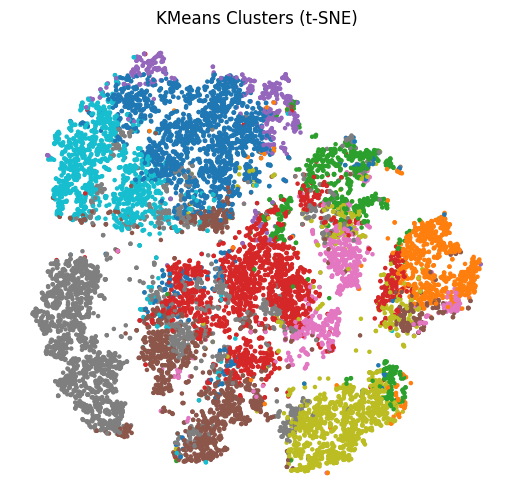

In [ ]:
from sklearn.manifold import TSNE

# t-SNE Visualization
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_test_pca)

plt.figure(figsize=(14, 6))

# KMeans
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_test_preds, cmap='tab10', s=5)
plt.title("KMeans Clusters (t-SNE)")
plt.axis('off')


#### T-SNE for GMM

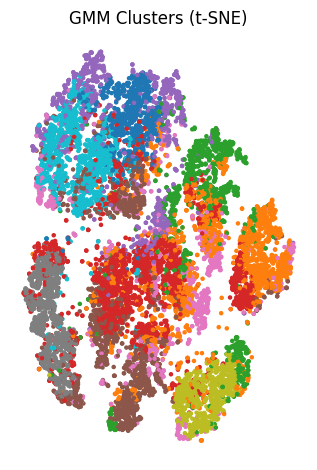

In [ ]:
# GMM
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_test_preds, cmap='tab10', s=5)
plt.title("GMM Clusters (t-SNE)")
plt.axis('off')

plt.tight_layout()
plt.show()


## VaDE Implementation

## Importing Libraries, defining helper functions

In [1]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

In [2]:
GLOBAL_SEED = 123

This function is for calcualting cluster accuracy, it uses a technique called hungarian matching

In [3]:
from scipy.optimize import linear_sum_assignment
def cluster_acc(Y_pred, Y):
    assert Y_pred.size == Y.size
    D = int(max(Y_pred.max(), Y.max()) + 1)
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return w[row_ind, col_ind].sum() * 1.0 / Y_pred.size, w

In [4]:
import random
def set_seed(s=GLOBAL_SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(GLOBAL_SEED)

## Loading Dataset

In [5]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset

def get_mnist(data_dir='./data/mnist/', batch_size=128):
    train = MNIST(root=data_dir, train=True, download=True)
    test = MNIST(root=data_dir, train=False, download=True)
    X = torch.cat([train.data.float().view(-1, 784) / 255., test.data.float().view(-1, 784) / 255.], 0)
    Y = torch.cat([train.targets, test.targets], 0)
    dataset = dict()
    dataset['X'] = X
    dataset['Y'] = Y
    dataloader = DataLoader(TensorDataset(X, Y), batch_size=batch_size, shuffle=True, num_workers=4)
    return dataloader, dataset

/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define the model

### Encoder, Decoder

In [6]:
def block(in_c, out_c):
    layers = [
        nn.Linear(in_c, out_c),
        nn.ReLU(True)
    ]
    return layers

class Encoder(nn.Module):
    def __init__(self, input_dim=784, inter_dims=[500, 500, 2000], hid_dim=10):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            *block(input_dim, inter_dims[0]),
            *block(inter_dims[0], inter_dims[1]),
            *block(inter_dims[1], inter_dims[2]),
        )
        self.mu_l = nn.Linear(inter_dims[-1], hid_dim)
        self.log_sigma2_l = nn.Linear(inter_dims[-1], hid_dim)

    def forward(self, x):
        e = self.encoder(x)
        mu = self.mu_l(e)
        log_sigma2 = self.log_sigma2_l(e)
        return mu, log_sigma2

class Decoder(nn.Module):
    def __init__(self, input_dim=784, inter_dims=[500, 500, 2000], hid_dim=10):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            *block(hid_dim, inter_dims[-1]),
            *block(inter_dims[-1], inter_dims[-2]),
            *block(inter_dims[-2], inter_dims[-3]),
            nn.Linear(inter_dims[-3], input_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        x_dec = self.decoder(z)
        return x_dec

In [7]:
class VaDE(nn.Module):
    def __init__(self, args):
        super(VaDE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

        self.pi_ = nn.Parameter(torch.FloatTensor(args.nClusters,).fill_(1) / args.nClusters, requires_grad=True)
        self.mu_c = nn.Parameter(torch.FloatTensor(args.nClusters, args.hid_dim).fill_(0), requires_grad=True)
        self.log_sigma2_c = nn.Parameter(torch.FloatTensor(args.nClusters, args.hid_dim).fill_(0), requires_grad=True)
        self.args = args

    def pre_train(self, dataloader, pre_epoch=10):
        if not os.path.exists('./pretrain_model3.pk'):
            Loss = nn.MSELoss()
            opti = Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()))
            print('Pretraining......')
            for epoch in range(pre_epoch):
                print(f"pretrain epoch: {epoch+1}/{pre_epoch}")
                L = 0
                for x, y in dataloader: #tqdm(dataloader, leave=False):
                    if self.args.cuda:
                        x = x.cuda()
                    z, _ = self.encoder(x)
                    x_ = self.decoder(z)
                    loss = Loss(x, x_)
                    L += loss.detach().cpu().numpy()
                    opti.zero_grad()
                    loss.backward()
                    opti.step()
                print('L2={:.4f}'.format(L / len(dataloader)))

                # Compute Clustering performance
                Z = []
                Y = []
                with torch.no_grad():
                    for x, y in dataloader:
                        if self.args.cuda:
                            x = x.cuda()
                        z_mu, _ = self.encoder(x)
                        Z.append(z_mu)
                        Y.append(y)
                Z = torch.cat(Z, 0).cpu().numpy()
                Y = torch.cat(Y, 0).cpu().numpy()
                gmm_temp = GaussianMixture(n_components=self.args.nClusters, covariance_type='diag', random_state=GLOBAL_SEED)
                pre_temp = gmm_temp.fit_predict(Z)
                acc_temp = cluster_acc(pre_temp, Y)[0] * 100
                print(f"Clustering accuracy at epoch {epoch+1}: {acc_temp:.2f}%")


            self.encoder.log_sigma2_l.load_state_dict(self.encoder.mu_l.state_dict())

            Z = []
            Y = []
            with torch.no_grad():
                for x, y in dataloader:
                    if self.args.cuda:
                        x = x.cuda()
                    z1, z2 = self.encoder(x)
                    assert F.mse_loss(z1, z2) == 0
                    Z.append(z1)
                    Y.append(y)

            Z = torch.cat(Z, 0).detach().cpu().numpy()
            Y = torch.cat(Y, 0).detach().numpy()

            # Try multiple GMM initializations and pick the best
            best_acc = -1
            best_gmm = None

            for trial in range(5):  # you can increase this number
                gmm_candidate = GaussianMixture(
                    n_components=self.args.nClusters,
                    covariance_type='diag',
                    random_state=GLOBAL_SEED + trial  # change seed each time
                )
                pre_candidate = gmm_candidate.fit_predict(Z)
                acc_candidate = cluster_acc(pre_candidate, Y)[0] * 100
                print(f"[GMM Trial {trial+1}] Accuracy = {acc_candidate:.2f}%")

                if acc_candidate > best_acc:
                    best_acc = acc_candidate
                    best_gmm = gmm_candidate

            print(f"Best GMM accuracy = {best_acc:.2f}%")

            # Use the best GMM parameters
            self.pi_.data = torch.from_numpy(best_gmm.weights_).cuda().float()
            self.mu_c.data = torch.from_numpy(best_gmm.means_).cuda().float()
            self.log_sigma2_c.data = torch.log(torch.from_numpy(best_gmm.covariances_).cuda().float())
            torch.save(self.state_dict(), './pretrain_model3.pk')

            # gmm = GaussianMixture(n_components=self.args.nClusters, covariance_type='diag', random_state=GLOBAL_SEED)
            # pre = gmm.fit_predict(Z)
            # print('Acc={:.4f}%'.format(cluster_acc(pre, Y)[0] * 100))
            # self.pi_.data = torch.from_numpy(gmm.weights_).cuda().float()
            # self.mu_c.data = torch.from_numpy(gmm.means_).cuda().float()
            # self.log_sigma2_c.data = torch.log(torch.from_numpy(gmm.covariances_).cuda().float())
            # torch.save(self.state_dict(), './pretrain_model3.pk')
        else:
            self.load_state_dict(torch.load('./pretrain_model3.pk'))

    def predict(self, x):
        z_mu, z_sigma2_log = self.encoder(x)
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        pi = self.pi_
        log_sigma2_c = self.log_sigma2_c
        mu_c = self.mu_c
        eta_c = torch.exp(torch.log(pi.unsqueeze(0)) + self.gaussian_pdfs_log(z, mu_c, log_sigma2_c))
        eta = eta_c.detach().cpu().numpy()
        return np.argmax(eta, axis=1)

    def ELBO_Loss(self, x, L=1):
        det = 1e-10
        L_rec = 0
        z_mu, z_sigma2_log = self.encoder(x)
        for l in range(L):
            z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
            x_pro = self.decoder(z)
            L_rec += F.binary_cross_entropy(x_pro, x)
        L_rec /= L
        Loss = L_rec * x.size(1)
        pi = self.pi_
        log_sigma2_c = self.log_sigma2_c
        mu_c = self.mu_c
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        eta_c = torch.exp(torch.log(pi.unsqueeze(0)) + self.gaussian_pdfs_log(z, mu_c, log_sigma2_c)) + det
        eta_c = eta_c / (eta_c.sum(1).view(-1, 1))
        Loss += 0.5 * torch.mean(torch.sum(
            eta_c * torch.sum(
                log_sigma2_c.unsqueeze(0) +
                torch.exp(z_sigma2_log.unsqueeze(1) - log_sigma2_c.unsqueeze(0)) +
                (z_mu.unsqueeze(1) - mu_c.unsqueeze(0)).pow(2) / torch.exp(log_sigma2_c.unsqueeze(0)),
            2), 1))
        Loss -= torch.mean(torch.sum(eta_c * torch.log(pi.unsqueeze(0) / (eta_c)), 1)) + 0.5 * torch.mean(torch.sum(1 + z_sigma2_log, 1))
        return Loss

    def gaussian_pdfs_log(self, x, mus, log_sigma2s):
        G = []
        for c in range(self.args.nClusters):
            G.append(self.gaussian_pdf_log(x, mus[c:c+1, :], log_sigma2s[c:c+1, :]).view(-1, 1))
        return torch.cat(G, 1)

    @staticmethod
    def gaussian_pdf_log(x, mu, log_sigma2):
        return -0.5 * (torch.sum(np.log(np.pi * 2) + log_sigma2 + (x - mu).pow(2) / torch.exp(log_sigma2), 1))


In [8]:
import matplotlib.pyplot as plt

In [9]:
class Args:
    def __init__(self, batch_size=800, datadir='./data/mnist', nClusters=10, hid_dim=10, cuda=True):
        self.batch_size = batch_size
        self.datadir = datadir
        self.nClusters = nClusters
        self.hid_dim = hid_dim
        self.cuda = cuda


args = Args(batch_size=800, datadir='./data/mnist', nClusters=10, hid_dim=10, cuda=True)

data_loader, _ = get_mnist(args.datadir, args.batch_size)

In [10]:
# Preload all data once after dataloader creation
full_X = data_loader.dataset.tensors[0]  # TensorDataset(X, Y)
full_Y = data_loader.dataset.tensors[1]
if args.cuda:
    full_X = full_X.cuda()

def plot_latent_tsne(model, X_data, y_data, subset_size=2000, title="t-SNE of VaDE Latent Space"):
    model.eval()
    subset_size = min(subset_size, len(X_data))
    idx = np.random.choice(len(X_data), subset_size, replace=False)
    X_subset = X_data[idx]
    y_subset = y_data[idx]

    with torch.no_grad():
        mu, _ = model.module.encoder(X_subset)  # module. because DataParallel
        latents = mu.cpu().numpy()

    tsne_result = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=400).fit_transform(latents)

    plt.figure(figsize=(5, 4))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_subset.cpu(), cmap='tab10', s=2)
    plt.title(title)
    plt.colorbar(scatter, ticks=range(args.nClusters))
    plt.show()

## Pretrain and Train routine

In [11]:
vade = VaDE(args)
if args.cuda:
    vade = vade.cuda()
    vade = nn.DataParallel(vade, device_ids=range(4))

print("pretraining")
vade.module.pre_train(data_loader, pre_epoch=25)
print("pretraining end\n")

pretraining
Pretraining......
pretrain epoch: 1/25


L2=0.0750


Clustering accuracy at epoch 1: 27.97%
pretrain epoch: 2/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0517


Clustering accuracy at epoch 2: 48.66%
pretrain epoch: 3/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0351


Clustering accuracy at epoch 3: 59.30%
pretrain epoch: 4/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0291


Clustering accuracy at epoch 4: 58.54%
pretrain epoch: 5/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0260


Clustering accuracy at epoch 5: 49.85%
pretrain epoch: 6/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0234


Clustering accuracy at epoch 6: 61.01%
pretrain epoch: 7/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0209


Clustering accuracy at epoch 7: 58.85%
pretrain epoch: 8/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0190


Clustering accuracy at epoch 8: 59.43%
pretrain epoch: 9/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0179


Clustering accuracy at epoch 9: 60.35%
pretrain epoch: 10/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0171


Clustering accuracy at epoch 10: 66.38%
pretrain epoch: 11/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0164


Clustering accuracy at epoch 11: 57.63%
pretrain epoch: 12/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0159


Clustering accuracy at epoch 12: 62.36%
pretrain epoch: 13/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0153


Clustering accuracy at epoch 13: 69.55%
pretrain epoch: 14/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0147


Clustering accuracy at epoch 14: 64.56%
pretrain epoch: 15/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0142


Clustering accuracy at epoch 15: 65.29%
pretrain epoch: 16/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0138


Clustering accuracy at epoch 16: 72.02%
pretrain epoch: 17/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0135


Clustering accuracy at epoch 17: 71.94%
pretrain epoch: 18/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0132


Clustering accuracy at epoch 18: 77.45%
pretrain epoch: 19/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0129


Clustering accuracy at epoch 19: 77.40%
pretrain epoch: 20/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0127


Clustering accuracy at epoch 20: 73.63%
pretrain epoch: 21/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0124


Clustering accuracy at epoch 21: 67.93%
pretrain epoch: 22/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0122


Clustering accuracy at epoch 22: 68.55%
pretrain epoch: 23/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0120


Clustering accuracy at epoch 23: 65.82%
pretrain epoch: 24/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0119


Clustering accuracy at epoch 24: 66.20%
pretrain epoch: 25/25


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L2=0.0118


Clustering accuracy at epoch 25: 76.35%


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[GMM Trial 1] Accuracy = 66.40%


[GMM Trial 2] Accuracy = 69.83%


[GMM Trial 3] Accuracy = 69.83%


[GMM Trial 4] Accuracy = 86.72%


[GMM Trial 5] Accuracy = 56.71%
Best GMM accuracy = 86.72%
pretraining end



/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1/300, Loss=160.5560,ACC=73.0986%,LR=0.0020


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


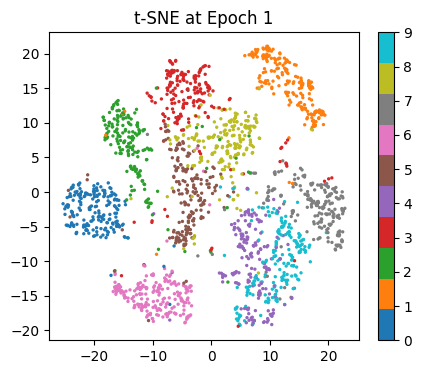

/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 2/300, Loss=110.7135,ACC=78.1057%,LR=0.0020


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 3/300, Loss=106.0413,ACC=80.8586%,LR=0.0020


Epoch: 4/300, Loss=103.8564,ACC=82.3600%,LR=0.0020


Epoch: 5/300, Loss=102.5158,ACC=83.9329%,LR=0.0020


Epoch: 6/300, Loss=101.2481,ACC=84.2843%,LR=0.0020


Epoch: 7/300, Loss=100.6354,ACC=84.6114%,LR=0.0020


Epoch: 8/300, Loss=99.8239,ACC=85.2643%,LR=0.0020


Epoch: 9/300, Loss=99.1965,ACC=85.6457%,LR=0.0020


Epoch: 10/300, Loss=98.7432,ACC=85.9371%,LR=0.0018


Epoch: 11/300, Loss=98.0224,ACC=86.2529%,LR=0.0019


Epoch: 12/300, Loss=97.4946,ACC=86.7000%,LR=0.0019


Epoch: 13/300, Loss=97.2951,ACC=86.9614%,LR=0.0019


Epoch: 14/300, Loss=96.9102,ACC=87.1786%,LR=0.0019


Epoch: 15/300, Loss=96.4978,ACC=87.2629%,LR=0.0019


Epoch: 16/300, Loss=96.2995,ACC=87.6214%,LR=0.0019


Epoch: 17/300, Loss=95.8520,ACC=87.6871%,LR=0.0019


Epoch: 18/300, Loss=95.7089,ACC=87.9143%,LR=0.0019


Epoch: 19/300, Loss=95.4940,ACC=88.2243%,LR=0.0019


Epoch: 20/300, Loss=95.1302,ACC=88.3486%,LR=0.0017


Epoch: 21/300, Loss=94.8402,ACC=88.6057%,LR=0.0018


Epoch: 22/300, Loss=94.6013,ACC=88.8571%,LR=0.0018


Epoch: 23/300, Loss=94.3970,ACC=88.8914%,LR=0.0018


Epoch: 24/300, Loss=94.2445,ACC=89.1829%,LR=0.0018


Epoch: 25/300, Loss=94.0646,ACC=89.5700%,LR=0.0018


Epoch: 26/300, Loss=93.7733,ACC=89.6914%,LR=0.0018


Epoch: 27/300, Loss=93.7475,ACC=89.6557%,LR=0.0018


Epoch: 28/300, Loss=93.4376,ACC=89.8971%,LR=0.0018


Epoch: 29/300, Loss=93.3713,ACC=90.1714%,LR=0.0018


Epoch: 30/300, Loss=93.1571,ACC=90.3900%,LR=0.0016


Epoch: 31/300, Loss=92.9766,ACC=90.4743%,LR=0.0017


Epoch: 32/300, Loss=92.9111,ACC=90.7057%,LR=0.0017


Epoch: 33/300, Loss=92.6623,ACC=90.9900%,LR=0.0017


Epoch: 34/300, Loss=92.4161,ACC=91.0871%,LR=0.0017


Epoch: 35/300, Loss=92.4191,ACC=91.1900%,LR=0.0017


Epoch: 36/300, Loss=92.2619,ACC=91.3257%,LR=0.0017


Epoch: 37/300, Loss=92.1284,ACC=91.6800%,LR=0.0017


Epoch: 38/300, Loss=92.0465,ACC=91.7814%,LR=0.0017


Epoch: 39/300, Loss=91.9000,ACC=91.7743%,LR=0.0017


Epoch: 40/300, Loss=91.9989,ACC=91.9057%,LR=0.0015


Epoch: 41/300, Loss=91.5171,ACC=92.0829%,LR=0.0016


Epoch: 42/300, Loss=91.5277,ACC=92.3043%,LR=0.0016


Epoch: 43/300, Loss=91.5003,ACC=92.2829%,LR=0.0016


Epoch: 44/300, Loss=91.2293,ACC=92.4057%,LR=0.0016


Epoch: 45/300, Loss=91.2878,ACC=92.6257%,LR=0.0016


Epoch: 46/300, Loss=91.0884,ACC=92.9000%,LR=0.0016


Epoch: 47/300, Loss=90.9973,ACC=92.8743%,LR=0.0016


Epoch: 48/300, Loss=91.0288,ACC=93.0243%,LR=0.0016


Epoch: 49/300, Loss=90.9189,ACC=92.8843%,LR=0.0016


Epoch: 50/300, Loss=90.8173,ACC=93.2743%,LR=0.0015


Epoch: 51/300, Loss=90.5739,ACC=93.2471%,LR=0.0015


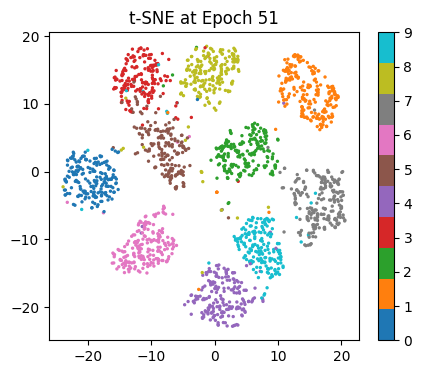

/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 52/300, Loss=90.5088,ACC=93.2743%,LR=0.0015


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 53/300, Loss=90.4381,ACC=93.4543%,LR=0.0015


Epoch: 54/300, Loss=90.3163,ACC=93.3371%,LR=0.0015


Epoch: 55/300, Loss=90.2759,ACC=93.5471%,LR=0.0015


Epoch: 56/300, Loss=90.1824,ACC=93.6700%,LR=0.0015


Epoch: 57/300, Loss=90.1813,ACC=93.7457%,LR=0.0015


Epoch: 58/300, Loss=90.0690,ACC=93.8314%,LR=0.0015


Epoch: 59/300, Loss=90.0425,ACC=93.9014%,LR=0.0015


Epoch: 60/300, Loss=89.8910,ACC=93.8771%,LR=0.0014


Epoch: 61/300, Loss=89.6579,ACC=93.8857%,LR=0.0015


Epoch: 62/300, Loss=89.6267,ACC=94.0386%,LR=0.0015


Epoch: 63/300, Loss=89.6456,ACC=94.2557%,LR=0.0015


Epoch: 64/300, Loss=89.7123,ACC=94.1514%,LR=0.0015


Epoch: 65/300, Loss=89.5182,ACC=94.1543%,LR=0.0015


Epoch: 66/300, Loss=89.4225,ACC=94.3343%,LR=0.0015


Epoch: 67/300, Loss=89.2361,ACC=94.2443%,LR=0.0015


Epoch: 68/300, Loss=89.3891,ACC=94.3271%,LR=0.0015


Epoch: 69/300, Loss=89.3131,ACC=94.4043%,LR=0.0015


Epoch: 70/300, Loss=89.1817,ACC=94.5286%,LR=0.0013


Epoch: 71/300, Loss=89.0893,ACC=94.5629%,LR=0.0014


Epoch: 72/300, Loss=88.9097,ACC=94.5943%,LR=0.0014


Epoch: 73/300, Loss=88.7944,ACC=94.6471%,LR=0.0014


Epoch: 74/300, Loss=88.8260,ACC=94.6514%,LR=0.0014


Epoch: 75/300, Loss=88.8338,ACC=94.6514%,LR=0.0014


Epoch: 76/300, Loss=88.7233,ACC=94.7157%,LR=0.0014


Epoch: 77/300, Loss=88.7339,ACC=94.6914%,LR=0.0014


Epoch: 78/300, Loss=88.6528,ACC=94.7271%,LR=0.0014


Epoch: 79/300, Loss=88.5561,ACC=94.7900%,LR=0.0014


Epoch: 80/300, Loss=88.5431,ACC=94.8400%,LR=0.0013


Epoch: 81/300, Loss=88.4553,ACC=94.8457%,LR=0.0013


Epoch: 82/300, Loss=88.3399,ACC=94.9186%,LR=0.0013


Epoch: 83/300, Loss=88.2630,ACC=94.9200%,LR=0.0013


Epoch: 84/300, Loss=88.2166,ACC=94.8700%,LR=0.0013


Epoch: 85/300, Loss=88.1556,ACC=94.9314%,LR=0.0013


Epoch: 86/300, Loss=88.0999,ACC=94.9586%,LR=0.0013


Epoch: 87/300, Loss=88.1928,ACC=95.0243%,LR=0.0013


Epoch: 88/300, Loss=88.0977,ACC=95.0100%,LR=0.0013


Epoch: 89/300, Loss=88.0405,ACC=95.1200%,LR=0.0013


Epoch: 90/300, Loss=87.9345,ACC=95.0643%,LR=0.0012


Epoch: 91/300, Loss=87.7752,ACC=95.0743%,LR=0.0013


Epoch: 92/300, Loss=87.7906,ACC=95.1729%,LR=0.0013


Epoch: 93/300, Loss=87.7415,ACC=95.1729%,LR=0.0013


Epoch: 94/300, Loss=87.7092,ACC=95.1386%,LR=0.0013


Epoch: 95/300, Loss=87.6561,ACC=95.3229%,LR=0.0013


Epoch: 96/300, Loss=87.6483,ACC=95.2100%,LR=0.0013


Epoch: 97/300, Loss=87.5780,ACC=95.1586%,LR=0.0013


Epoch: 98/300, Loss=87.5947,ACC=95.3000%,LR=0.0013


Epoch: 99/300, Loss=87.6153,ACC=95.2443%,LR=0.0013


Epoch: 100/300, Loss=87.4794,ACC=95.1771%,LR=0.0011


Epoch: 101/300, Loss=87.3226,ACC=95.3129%,LR=0.0012


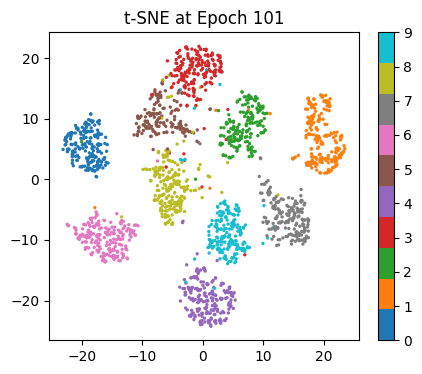

/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 102/300, Loss=87.2402,ACC=95.4471%,LR=0.0012


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 103/300, Loss=87.2359,ACC=95.3043%,LR=0.0012


Epoch: 104/300, Loss=87.2864,ACC=95.2971%,LR=0.0012


Epoch: 105/300, Loss=87.2018,ACC=95.3857%,LR=0.0012


Epoch: 106/300, Loss=87.1843,ACC=95.3443%,LR=0.0012


Epoch: 107/300, Loss=87.0909,ACC=95.4186%,LR=0.0012


Epoch: 108/300, Loss=87.0488,ACC=95.4386%,LR=0.0012


Epoch: 109/300, Loss=87.0462,ACC=95.4500%,LR=0.0012


Epoch: 110/300, Loss=86.9965,ACC=95.4614%,LR=0.0011


Epoch: 111/300, Loss=86.9162,ACC=95.5171%,LR=0.0011


Epoch: 112/300, Loss=86.8348,ACC=95.4771%,LR=0.0011


Epoch: 113/300, Loss=86.7795,ACC=95.5129%,LR=0.0011


Epoch: 114/300, Loss=86.8303,ACC=95.5171%,LR=0.0011


Epoch: 115/300, Loss=86.7987,ACC=95.5086%,LR=0.0011


Epoch: 116/300, Loss=86.7769,ACC=95.5586%,LR=0.0011


Epoch: 117/300, Loss=86.7823,ACC=95.4700%,LR=0.0011


Epoch: 118/300, Loss=86.7046,ACC=95.5543%,LR=0.0011


Epoch: 119/300, Loss=86.6870,ACC=95.5571%,LR=0.0011


Epoch: 120/300, Loss=86.5913,ACC=95.5929%,LR=0.0010


Epoch: 121/300, Loss=86.4927,ACC=95.6357%,LR=0.0011


Epoch: 122/300, Loss=86.4189,ACC=95.6829%,LR=0.0011


Epoch: 123/300, Loss=86.4201,ACC=95.5900%,LR=0.0011


Epoch: 124/300, Loss=86.4183,ACC=95.6357%,LR=0.0011


Epoch: 125/300, Loss=86.3475,ACC=95.5843%,LR=0.0011


Epoch: 126/300, Loss=86.3364,ACC=95.7114%,LR=0.0011


Epoch: 127/300, Loss=86.2810,ACC=95.6043%,LR=0.0011


Epoch: 128/300, Loss=86.2743,ACC=95.6829%,LR=0.0011


Epoch: 129/300, Loss=86.3352,ACC=95.6371%,LR=0.0011


Epoch: 130/300, Loss=86.3113,ACC=95.6043%,LR=0.0010


Epoch: 131/300, Loss=86.1040,ACC=95.6357%,LR=0.0010


Epoch: 132/300, Loss=86.0431,ACC=95.7086%,LR=0.0010


Epoch: 133/300, Loss=85.9922,ACC=95.7486%,LR=0.0010


Epoch: 134/300, Loss=85.9986,ACC=95.7714%,LR=0.0010


Epoch: 135/300, Loss=85.9882,ACC=95.7857%,LR=0.0010


Epoch: 136/300, Loss=86.0482,ACC=95.7186%,LR=0.0010


Epoch: 137/300, Loss=86.0035,ACC=95.7471%,LR=0.0010


Epoch: 138/300, Loss=85.9538,ACC=95.7300%,LR=0.0010


Epoch: 139/300, Loss=85.9288,ACC=95.7214%,LR=0.0010


Epoch: 140/300, Loss=85.9910,ACC=95.7643%,LR=0.0009


Epoch: 141/300, Loss=85.7540,ACC=95.7771%,LR=0.0010


Epoch: 142/300, Loss=85.7319,ACC=95.7400%,LR=0.0010


Epoch: 143/300, Loss=85.7628,ACC=95.8586%,LR=0.0010


Epoch: 144/300, Loss=85.7402,ACC=95.7757%,LR=0.0010


Epoch: 145/300, Loss=85.7164,ACC=95.8429%,LR=0.0010


Epoch: 146/300, Loss=85.6619,ACC=95.8129%,LR=0.0010


Epoch: 147/300, Loss=85.6514,ACC=95.6986%,LR=0.0010


Epoch: 148/300, Loss=85.6798,ACC=95.7943%,LR=0.0010


Epoch: 149/300, Loss=85.6527,ACC=95.8243%,LR=0.0010


Epoch: 150/300, Loss=85.5912,ACC=95.8686%,LR=0.0009


Epoch: 151/300, Loss=85.5224,ACC=95.8829%,LR=0.0009


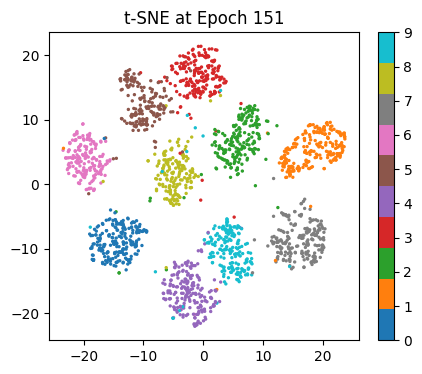

/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 152/300, Loss=85.4334,ACC=95.8571%,LR=0.0009


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 153/300, Loss=85.4466,ACC=95.8871%,LR=0.0009


Epoch: 154/300, Loss=85.4629,ACC=95.9000%,LR=0.0009


Epoch: 155/300, Loss=85.3970,ACC=95.8029%,LR=0.0009


Epoch: 156/300, Loss=85.3704,ACC=95.8129%,LR=0.0009


Epoch: 157/300, Loss=85.3666,ACC=95.8714%,LR=0.0009


Epoch: 158/300, Loss=85.3334,ACC=95.9071%,LR=0.0009


Epoch: 159/300, Loss=85.3616,ACC=95.9171%,LR=0.0009


Epoch: 160/300, Loss=85.3154,ACC=95.8514%,LR=0.0008


Epoch: 161/300, Loss=85.2000,ACC=95.8829%,LR=0.0009


Epoch: 162/300, Loss=85.1433,ACC=95.8671%,LR=0.0009


Epoch: 163/300, Loss=85.2092,ACC=95.9143%,LR=0.0009


Epoch: 164/300, Loss=85.1632,ACC=95.9314%,LR=0.0009


Epoch: 165/300, Loss=85.1340,ACC=95.8886%,LR=0.0009


Epoch: 166/300, Loss=85.1171,ACC=95.8743%,LR=0.0009


Epoch: 167/300, Loss=85.1051,ACC=95.8314%,LR=0.0009


Epoch: 168/300, Loss=85.0849,ACC=95.9086%,LR=0.0009


Epoch: 169/300, Loss=85.0684,ACC=95.8471%,LR=0.0009


Epoch: 170/300, Loss=85.0315,ACC=96.0229%,LR=0.0008


Epoch: 171/300, Loss=84.9191,ACC=95.9886%,LR=0.0008


Epoch: 172/300, Loss=84.9163,ACC=95.9586%,LR=0.0008


Epoch: 173/300, Loss=84.8900,ACC=95.9957%,LR=0.0008


Epoch: 174/300, Loss=84.9164,ACC=95.9729%,LR=0.0008


Epoch: 175/300, Loss=84.8999,ACC=95.8686%,LR=0.0008


Epoch: 176/300, Loss=84.8414,ACC=95.8957%,LR=0.0008


Epoch: 177/300, Loss=84.8402,ACC=95.9643%,LR=0.0008


Epoch: 178/300, Loss=84.8671,ACC=96.0357%,LR=0.0008


Epoch: 179/300, Loss=84.8059,ACC=96.0271%,LR=0.0008


Epoch: 180/300, Loss=84.8227,ACC=96.0971%,LR=0.0008


Epoch: 181/300, Loss=84.7483,ACC=96.0229%,LR=0.0008


Epoch: 182/300, Loss=84.7039,ACC=95.9929%,LR=0.0008


Epoch: 183/300, Loss=84.6597,ACC=95.9657%,LR=0.0008


Epoch: 184/300, Loss=84.6292,ACC=95.9686%,LR=0.0008


Epoch: 185/300, Loss=84.6644,ACC=95.9929%,LR=0.0008


Epoch: 186/300, Loss=84.6386,ACC=96.0657%,LR=0.0008


Epoch: 187/300, Loss=84.6143,ACC=95.9943%,LR=0.0008


Epoch: 188/300, Loss=84.6374,ACC=95.9600%,LR=0.0008


Epoch: 189/300, Loss=84.6177,ACC=96.0471%,LR=0.0008


Epoch: 190/300, Loss=84.5956,ACC=95.9843%,LR=0.0007


Epoch: 191/300, Loss=84.4718,ACC=95.9800%,LR=0.0008


Epoch: 192/300, Loss=84.5003,ACC=95.9671%,LR=0.0008


Epoch: 193/300, Loss=84.4096,ACC=96.0429%,LR=0.0008


Epoch: 194/300, Loss=84.4134,ACC=96.0300%,LR=0.0008


Epoch: 195/300, Loss=84.4238,ACC=96.0300%,LR=0.0008


Epoch: 196/300, Loss=84.4208,ACC=96.0086%,LR=0.0008


Epoch: 197/300, Loss=84.3929,ACC=96.0729%,LR=0.0008


Epoch: 198/300, Loss=84.3750,ACC=96.0543%,LR=0.0008


Epoch: 199/300, Loss=84.3653,ACC=96.0157%,LR=0.0008


Epoch: 200/300, Loss=84.3160,ACC=96.0143%,LR=0.0007


Epoch: 201/300, Loss=84.2590,ACC=96.0414%,LR=0.0007


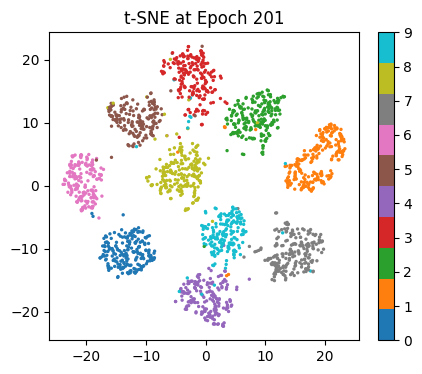

/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 202/300, Loss=84.2134,ACC=96.0329%,LR=0.0007


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 203/300, Loss=84.2698,ACC=96.0486%,LR=0.0007


Epoch: 204/300, Loss=84.2345,ACC=96.0486%,LR=0.0007


Epoch: 205/300, Loss=84.2229,ACC=96.0686%,LR=0.0007


Epoch: 206/300, Loss=84.2014,ACC=96.0757%,LR=0.0007


Epoch: 207/300, Loss=84.2103,ACC=96.0571%,LR=0.0007


Epoch: 208/300, Loss=84.1545,ACC=96.0414%,LR=0.0007


Epoch: 209/300, Loss=84.2087,ACC=96.1057%,LR=0.0007


Epoch: 210/300, Loss=84.1633,ACC=96.0443%,LR=0.0006


Epoch: 211/300, Loss=84.0786,ACC=96.0486%,LR=0.0007


Epoch: 212/300, Loss=84.0671,ACC=96.0543%,LR=0.0007


Epoch: 213/300, Loss=84.0425,ACC=96.0471%,LR=0.0007


Epoch: 214/300, Loss=84.0150,ACC=96.1200%,LR=0.0007


Epoch: 215/300, Loss=84.0357,ACC=96.1071%,LR=0.0007


Epoch: 216/300, Loss=84.0374,ACC=96.1057%,LR=0.0007


Epoch: 217/300, Loss=83.9939,ACC=96.1300%,LR=0.0007


Epoch: 218/300, Loss=83.9804,ACC=96.1086%,LR=0.0007


Epoch: 219/300, Loss=83.9726,ACC=96.0686%,LR=0.0007


Epoch: 220/300, Loss=83.9778,ACC=96.0771%,LR=0.0006


Epoch: 221/300, Loss=83.8899,ACC=96.1029%,LR=0.0006


Epoch: 222/300, Loss=83.8661,ACC=96.1586%,LR=0.0006


Epoch: 223/300, Loss=83.8790,ACC=96.1171%,LR=0.0006


Epoch: 224/300, Loss=83.8428,ACC=96.0986%,LR=0.0006


Epoch: 225/300, Loss=83.8413,ACC=96.2000%,LR=0.0006


Epoch: 226/300, Loss=83.8291,ACC=96.1229%,LR=0.0006


Epoch: 227/300, Loss=83.8044,ACC=96.1257%,LR=0.0006


Epoch: 228/300, Loss=83.8287,ACC=96.1886%,LR=0.0006


Epoch: 229/300, Loss=83.7963,ACC=96.1500%,LR=0.0006


Epoch: 230/300, Loss=83.7978,ACC=96.1357%,LR=0.0006


Epoch: 231/300, Loss=83.7567,ACC=96.2600%,LR=0.0006


Epoch: 232/300, Loss=83.7387,ACC=96.1000%,LR=0.0006


Epoch: 233/300, Loss=83.6920,ACC=96.1243%,LR=0.0006


Epoch: 234/300, Loss=83.7014,ACC=96.1471%,LR=0.0006


Epoch: 235/300, Loss=83.6601,ACC=96.1729%,LR=0.0006


Epoch: 236/300, Loss=83.6703,ACC=96.1600%,LR=0.0006


Epoch: 237/300, Loss=83.6690,ACC=96.1400%,LR=0.0006


Epoch: 238/300, Loss=83.6411,ACC=96.1014%,LR=0.0006


Epoch: 239/300, Loss=83.6392,ACC=96.0929%,LR=0.0006


Epoch: 240/300, Loss=83.6192,ACC=96.1957%,LR=0.0006


Epoch: 241/300, Loss=83.5445,ACC=96.1829%,LR=0.0006


Epoch: 242/300, Loss=83.5414,ACC=96.1714%,LR=0.0006


Epoch: 243/300, Loss=83.5458,ACC=96.1771%,LR=0.0006


Epoch: 244/300, Loss=83.5242,ACC=96.1743%,LR=0.0006


Epoch: 245/300, Loss=83.5338,ACC=96.1743%,LR=0.0006


Epoch: 246/300, Loss=83.5342,ACC=96.1429%,LR=0.0006


Epoch: 247/300, Loss=83.5147,ACC=96.1786%,LR=0.0006


Epoch: 248/300, Loss=83.5320,ACC=96.1157%,LR=0.0006


Epoch: 249/300, Loss=83.4916,ACC=96.1371%,LR=0.0006


Epoch: 250/300, Loss=83.4825,ACC=96.1900%,LR=0.0005


Epoch: 251/300, Loss=83.3888,ACC=96.1386%,LR=0.0006


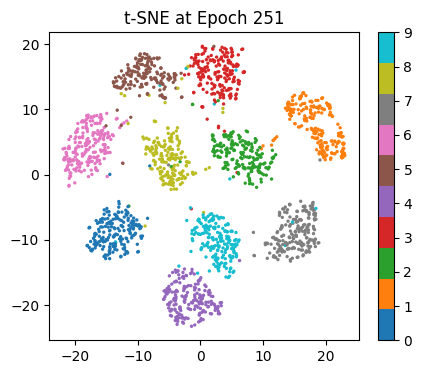

/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 252/300, Loss=83.3829,ACC=96.1871%,LR=0.0006


/home/akula.ha/.conda/envs/refseg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 253/300, Loss=83.3789,ACC=96.1400%,LR=0.0006


Epoch: 254/300, Loss=83.3633,ACC=96.2514%,LR=0.0006


Epoch: 255/300, Loss=83.3266,ACC=96.1700%,LR=0.0006


Epoch: 256/300, Loss=83.3460,ACC=96.1986%,LR=0.0006


Epoch: 257/300, Loss=83.3706,ACC=96.2029%,LR=0.0006


Epoch: 258/300, Loss=83.3584,ACC=96.2014%,LR=0.0006


Epoch: 259/300, Loss=83.3438,ACC=96.1543%,LR=0.0006


Epoch: 260/300, Loss=83.3184,ACC=96.1743%,LR=0.0005


Epoch: 261/300, Loss=83.2725,ACC=96.2471%,LR=0.0005


Epoch: 262/300, Loss=83.2443,ACC=96.2343%,LR=0.0005


Epoch: 263/300, Loss=83.2549,ACC=96.1771%,LR=0.0005


Epoch: 264/300, Loss=83.2499,ACC=96.2371%,LR=0.0005


Epoch: 265/300, Loss=83.2365,ACC=96.2771%,LR=0.0005


Epoch: 266/300, Loss=83.2232,ACC=96.2471%,LR=0.0005


Epoch: 267/300, Loss=83.2100,ACC=96.1700%,LR=0.0005


Epoch: 268/300, Loss=83.1873,ACC=96.2286%,LR=0.0005


Epoch: 269/300, Loss=83.1791,ACC=96.2000%,LR=0.0005


Epoch: 270/300, Loss=83.2076,ACC=96.2400%,LR=0.0005


Epoch: 271/300, Loss=83.1194,ACC=96.1929%,LR=0.0005


Epoch: 272/300, Loss=83.1460,ACC=96.2371%,LR=0.0005


Epoch: 273/300, Loss=83.0679,ACC=96.1729%,LR=0.0005


Epoch: 274/300, Loss=83.0930,ACC=96.1886%,LR=0.0005


Epoch: 275/300, Loss=83.1011,ACC=96.1686%,LR=0.0005


Epoch: 276/300, Loss=83.0757,ACC=96.2500%,LR=0.0005


Epoch: 277/300, Loss=83.0908,ACC=96.1686%,LR=0.0005


Epoch: 278/300, Loss=83.0421,ACC=96.2186%,LR=0.0005


Epoch: 279/300, Loss=83.0276,ACC=96.1829%,LR=0.0005


Epoch: 280/300, Loss=83.0535,ACC=96.2471%,LR=0.0005


Epoch: 281/300, Loss=82.9920,ACC=96.2257%,LR=0.0005


Epoch: 282/300, Loss=83.0148,ACC=96.2771%,LR=0.0005


Epoch: 283/300, Loss=82.9556,ACC=96.2314%,LR=0.0005


Epoch: 284/300, Loss=82.9625,ACC=96.2314%,LR=0.0005


Epoch: 285/300, Loss=82.9406,ACC=96.2257%,LR=0.0005


Epoch: 286/300, Loss=82.9415,ACC=96.2214%,LR=0.0005


Epoch: 287/300, Loss=82.9652,ACC=96.2343%,LR=0.0005


Epoch: 288/300, Loss=82.9239,ACC=96.2314%,LR=0.0005


Epoch: 289/300, Loss=82.9153,ACC=96.2457%,LR=0.0005


Epoch: 290/300, Loss=82.9162,ACC=96.2029%,LR=0.0004


Epoch: 291/300, Loss=82.8876,ACC=96.2429%,LR=0.0005


Epoch: 292/300, Loss=82.8610,ACC=96.2643%,LR=0.0005


Epoch: 293/300, Loss=82.8751,ACC=96.3386%,LR=0.0005


Epoch: 294/300, Loss=82.8366,ACC=96.2429%,LR=0.0005


Epoch: 295/300, Loss=82.8380,ACC=96.2300%,LR=0.0005


Epoch: 296/300, Loss=82.8298,ACC=96.2429%,LR=0.0005


Epoch: 297/300, Loss=82.8269,ACC=96.2286%,LR=0.0005


Epoch: 298/300, Loss=82.8143,ACC=96.2257%,LR=0.0005


Epoch: 299/300, Loss=82.8455,ACC=96.2429%,LR=0.0005


Epoch: 300/300, Loss=82.7985,ACC=96.1929%,LR=0.0004


In [12]:
opti = Adam(vade.parameters(), lr=2e-3)
lr_s = StepLR(opti, step_size=10, gamma=0.95)
train_epochs = 300
tsne = TSNE()

for epoch in range(train_epochs):
    
    L = 0
    for x, _ in data_loader: #tqdm(data_loader, leave=False):
        if args.cuda:
            x = x.cuda()
        loss = vade.module.ELBO_Loss(x)
        opti.zero_grad()
        loss.backward()
        opti.step()
        L += loss.detach().cpu().numpy()
    lr_s.step()

    pre = []
    tru = []
    with torch.no_grad():
        for x, y in data_loader:
            if args.cuda:
                x = x.cuda()
            tru.append(y.numpy())
            pre.append(vade.module.predict(x))
    tru = np.concatenate(tru, 0)
    pre = np.concatenate(pre, 0)
    print(f"Epoch: {epoch+1}/{train_epochs}", end=', ')
    print('Loss={:.4f},ACC={:.4f}%,LR={:.4f}'.format(L/len(data_loader), cluster_acc(pre, tru)[0]*100, lr_s.get_lr()[0]))

    if epoch % 50 == 0:
        plot_latent_tsne(vade, full_X, full_Y, subset_size=2000, title=f"t-SNE at Epoch {epoch+1}")

## Save Model

In [13]:
# Save after training
torch.save(vade.module.state_dict(), "vade_final3.pth")
print("Model saved to vade_final3.pth")

Model saved to vade_final3.pth


## Load Model

In [11]:
vade = VaDE(args)
if args.cuda:
    vade = vade.cuda()
    vade = nn.DataParallel(vade, device_ids=range(4))

vade.module.load_state_dict(torch.load("vade_final3.pth"))
vade.eval()

DataParallel(
  (module): VaDE(
    (encoder): Encoder(
      (encoder): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=500, out_features=500, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=500, out_features=2000, bias=True)
        (5): ReLU(inplace=True)
      )
      (mu_l): Linear(in_features=2000, out_features=10, bias=True)
      (log_sigma2_l): Linear(in_features=2000, out_features=10, bias=True)
    )
    (decoder): Decoder(
      (decoder): Sequential(
        (0): Linear(in_features=10, out_features=2000, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=2000, out_features=500, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=500, out_features=500, bias=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=500, out_features=784, bias=True)
        (7): Sigmoid()
      )
    )
  )
)

## Inference

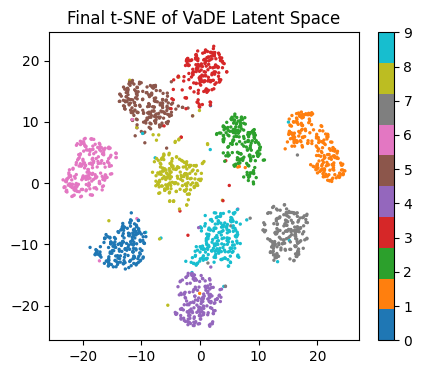

In [15]:
# Final t-SNE visualization on trained model
plot_latent_tsne(
    vade,
    full_X,
    full_Y,
    subset_size=2000,
    title="Final t-SNE of VaDE Latent Space"
)

In [28]:
from matplotlib.patches import Patch

def plot_latent_tsne_v2(model, X_data, y_data, subset_size=2000, title="t-SNE of VaDE Latent Space"):
    model.eval()
    idx = np.random.choice(len(X_data), min(subset_size, len(X_data)), replace=False)
    X_subset, y_subset = X_data[idx], y_data[idx]

    with torch.no_grad():
        mu, _ = model.module.encoder(X_subset)
    latents = mu.cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=400)
    tsne_result = tsne.fit_transform(latents)

    colors = plt.cm.tab10.colors
    plt.figure(figsize=(6, 5))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_subset.cpu(), cmap='tab10', s=5)

    # Inline cluster labels
    for i in range(args.nClusters):
        mask = (y_subset.cpu() == i)
        plt.text(tsne_result[mask, 0].mean(),
                 tsne_result[mask, 1].mean(),
                 str(i), fontsize=14, 
                 ha='center', va='center', weight='bold',
                 bbox=dict(facecolor='white', alpha=1, edgecolor='none', pad=1))

    # Simple legend
    legend_elems = [Patch(facecolor=colors[i], label=str(i)) for i in range(args.nClusters)]
    plt.legend(handles=legend_elems, title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(title)
    plt.tight_layout()
    plt.show()


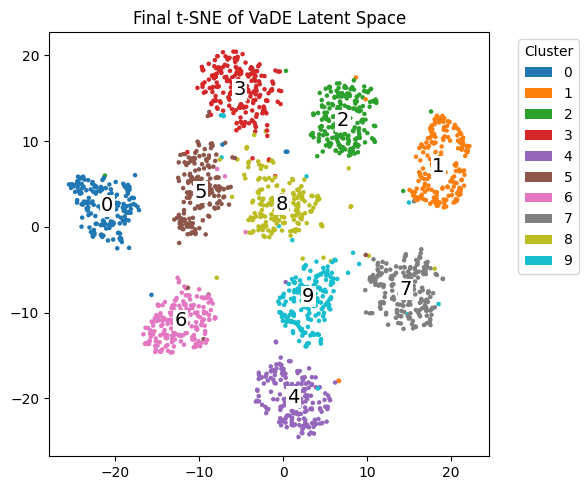

In [29]:
# Final t-SNE visualization on trained model
plot_latent_tsne_v2(
    vade,
    full_X,
    full_Y,
    subset_size=2000,
    title="Final t-SNE of VaDE Latent Space"
)

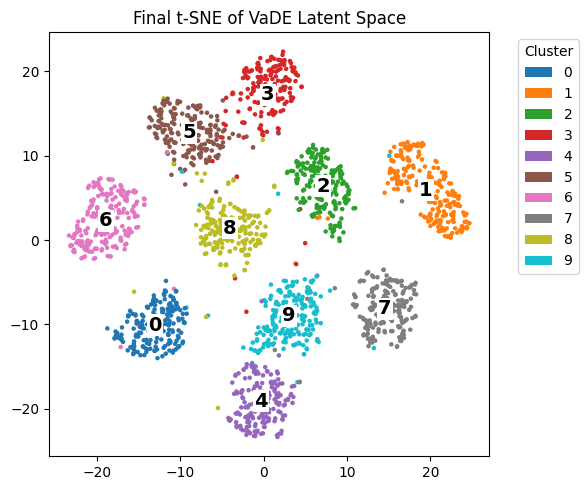

In [27]:
# Final t-SNE visualization on trained model
plot_latent_tsne_v2(
    vade,
    full_X,
    full_Y,
    subset_size=2000,
    title="Final t-SNE of VaDE Latent Space"
)

### Final clustering accuracy after training

In [ ]:
test_data_loader

In [20]:
Z = []
Y = []
with torch.no_grad():
    for x, y in data_loader:
        if args.cuda:
            x = x.cuda()
        z_mu, _ = vade.module.encoder(x)  # we need to use .module because we used DataParallel
        Z.append(z_mu)
        Y.append(y)

Z = torch.cat(Z, 0).cpu().numpy()
Y = torch.cat(Y, 0).cpu().numpy()

gmm = GaussianMixture(n_components=args.nClusters, covariance_type='diag', random_state=GLOBAL_SEED, n_init=10)
pre = gmm.fit_predict(Z)
acc = cluster_acc(pre, Y)[0] * 100
print(f"Final clustering ACC after training: {acc:.2f}%")

Final clustering ACC after training: 96.14%


In [25]:
def get_cluster_digit_mapping(vade, dataloader):
    # returns mapping from cluster index to digit label using Hungarian algorithm
    vade.eval()
    pre = []
    tru = []
    with torch.no_grad():
        for x, y in dataloader:
            if vade.module.args.cuda:
                x = x.cuda()
            tru.append(y.numpy())
            pre.append(vade.module.predict(x))
    tru = np.concatenate(tru)
    pre = np.concatenate(pre)

    # Confusion matrix for Hungarian
    D = max(pre.max(), tru.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(len(tru)):
        w[pre[i], tru[i]] += 1

    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    mapping = dict(zip(row_ind, col_ind))
    return mapping


In [26]:
def visualize_all_clusters_by_digit(vade, dataloader, n_samples=10):
    # show n_samples from each cluster, where we are ordering by the digits from 0 to 9
    mapping = get_cluster_digit_mapping(vade, dataloader)
    inv_mapping = {digit: cluster for cluster, digit in mapping.items()}

    fig, axes = plt.subplots(len(inv_mapping), n_samples, figsize=(n_samples * 0.75, len(inv_mapping) * 0.75))
    
    for digit in range(len(inv_mapping)):
        k = inv_mapping[digit]
        mu_c = vade.module.mu_c[k]
        log_sigma2_c = vade.module.log_sigma2_c[k]
        sigma_c = torch.exp(0.5 * log_sigma2_c)

        z = mu_c + sigma_c * torch.randn(n_samples, mu_c.shape[0], device=mu_c.device)
        with torch.no_grad():
            x_gen = vade.module.decoder(z).cpu().numpy()

        for i in range(n_samples):
            axes[digit, i].imshow(x_gen[i].reshape(28, 28), cmap="gray")
            axes[digit, i].axis("off")

    plt.suptitle("Samples from each digit (Hungarian aligned)", fontsize=14)
    plt.tight_layout()
    plt.show()

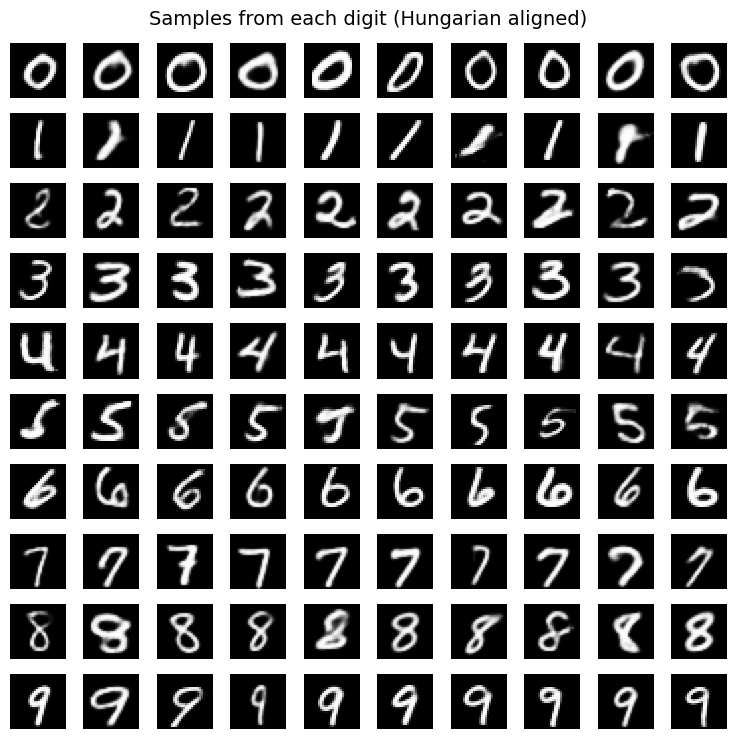

In [49]:
visualize_all_clusters_by_digit(vade, data_loader, n_samples=10)

In [23]:
def interpolate_within_digit(vade, digit, mapping, steps=8):
    # interpolate between two latents from the same digit cluster.
    
    model = vade.module if hasattr(vade, "module") else vade
    cluster_id = [c for c, d in mapping.items() if d == digit][0]
    
    mu_c = model.mu_c[cluster_id]
    sigma_c = torch.exp(0.5 * model.log_sigma2_c[cluster_id])
    
    # two random samples in the cluster
    z1 = mu_c + sigma_c * torch.randn_like(mu_c)
    z2 = mu_c + sigma_c * torch.randn_like(mu_c)
    
    alphas = np.linspace(0, 1, steps)
    imgs = []
    with torch.no_grad():
        for alpha in alphas:
            z = (1 - alpha) * z1 + alpha * z2
            img = model.decoder(z.unsqueeze(0)).cpu().numpy().reshape(28, 28)
            imgs.append(img)
    
    fig, axes = plt.subplots(1, steps, figsize=(steps*1.2, 1.2))
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i], cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Within-digit interpolation: {digit}")
    plt.show()

def interpolate_between_digits(vade, digit1, digit2, mapping, steps=8):
    # interpolate from one digit cluster to nother.
    model = vade.module if hasattr(vade, "module") else vade
    cluster1 = [c for c, d in mapping.items() if d == digit1][0]
    cluster2 = [c for c, d in mapping.items() if d == digit2][0]
    
    z1 = model.mu_c[cluster1]
    z2 = model.mu_c[cluster2]
    
    alphas = np.linspace(0, 1, steps)
    imgs = []
    with torch.no_grad():
        for alpha in alphas:
            z = (1 - alpha) * z1 + alpha * z2
            img = model.decoder(z.unsqueeze(0)).cpu().numpy().reshape(28, 28)
            imgs.append(img)
    
    fig, axes = plt.subplots(1, steps, figsize=(steps*1.2, 1.2))
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i], cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Digit {digit1} to Digit {digit2} interpolation")
    plt.show()


In [16]:
mapping = get_cluster_digit_mapping(vade, data_loader)

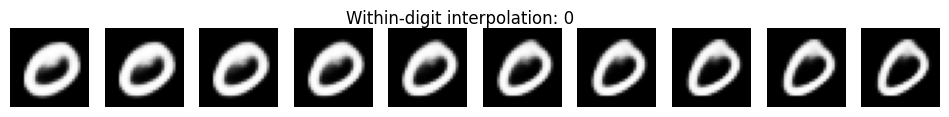

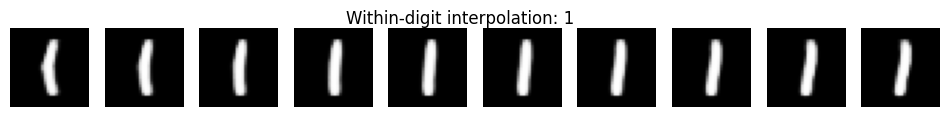

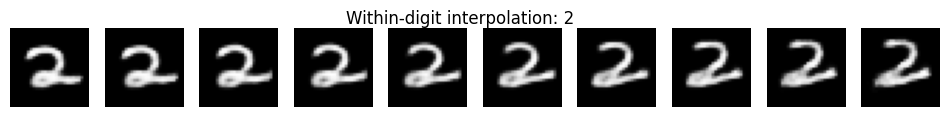

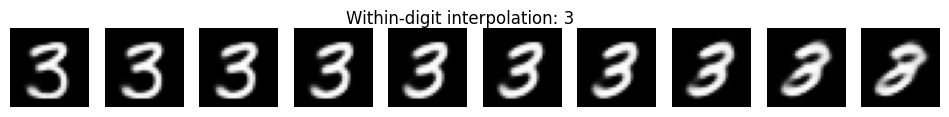

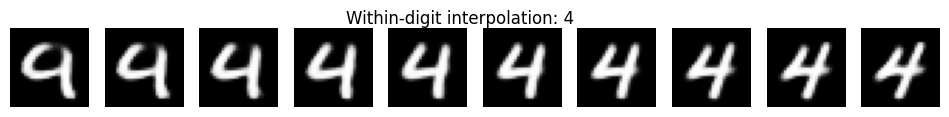

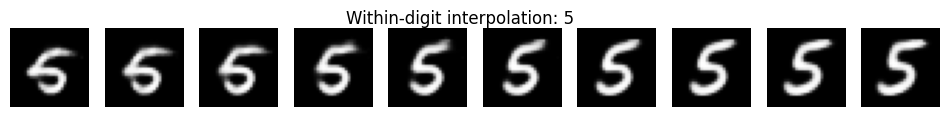

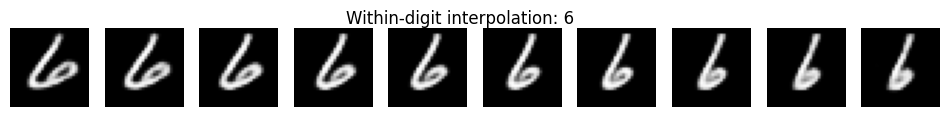

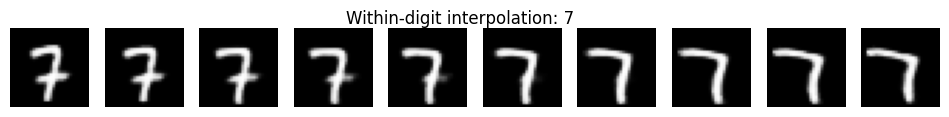

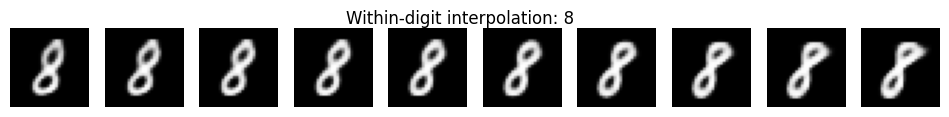

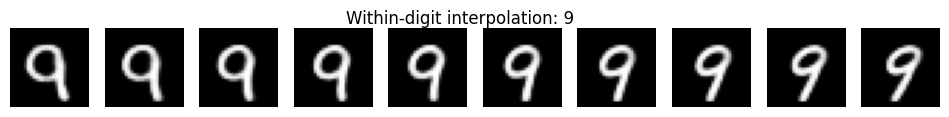

In [20]:
interpolate_within_digit(vade, digit=0, mapping=mapping, steps=10)
interpolate_within_digit(vade, digit=1, mapping=mapping, steps=10)
interpolate_within_digit(vade, digit=2, mapping=mapping, steps=10)
interpolate_within_digit(vade, digit=3, mapping=mapping, steps=10)
interpolate_within_digit(vade, digit=4, mapping=mapping, steps=10)
interpolate_within_digit(vade, digit=5, mapping=mapping, steps=10)
interpolate_within_digit(vade, digit=6, mapping=mapping, steps=10)
interpolate_within_digit(vade, digit=7, mapping=mapping, steps=10)
interpolate_within_digit(vade, digit=8, mapping=mapping, steps=10)
interpolate_within_digit(vade, digit=9, mapping=mapping, steps=10)


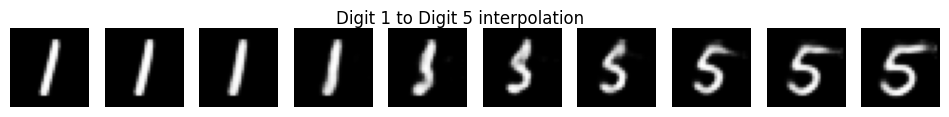

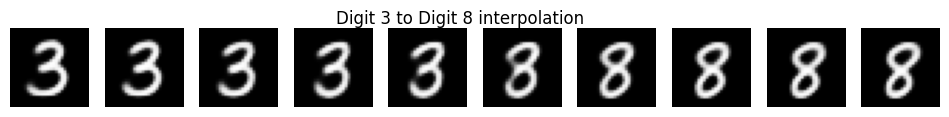

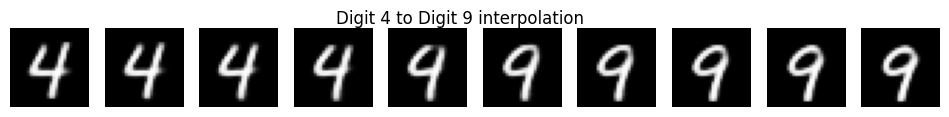

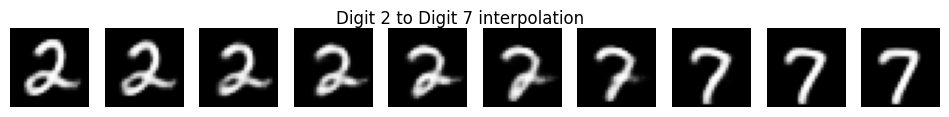

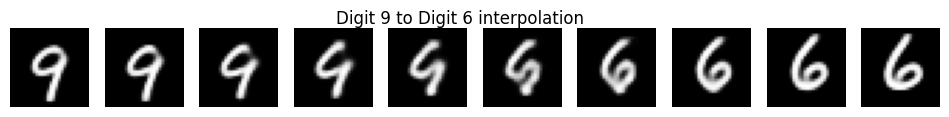

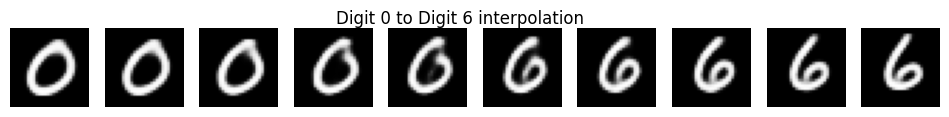

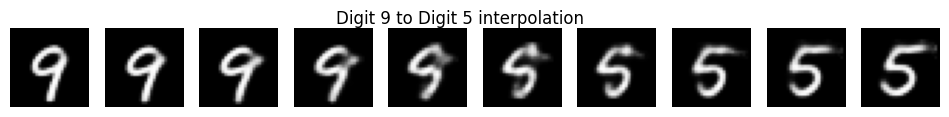

In [24]:
# Interpolate from digit 3 to digit 8
interpolate_between_digits(vade, digit1=1, digit2=5, mapping=mapping, steps=10)
interpolate_between_digits(vade, digit1=3, digit2=8, mapping=mapping, steps=10)
interpolate_between_digits(vade, digit1=4, digit2=9, mapping=mapping, steps=10)
interpolate_between_digits(vade, digit1=2, digit2=7, mapping=mapping, steps=10)
interpolate_between_digits(vade, digit1=9, digit2=6, mapping=mapping, steps=10)
interpolate_between_digits(vade, digit1=0, digit2=6, mapping=mapping, steps=10)
interpolate_between_digits(vade, digit1=9, digit2=5, mapping=mapping, steps=10)